# Data Preparation Step

* Import the needed libraries

In [142]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,InputLayer
from tensorflow.keras import callbacks
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix,classification_report

In [143]:
class HeartDiseaseData:
    def __init__(self, data_path):
        self.data_path = data_path
        self.df = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        self.df_encoded = None
        self.df_standardized = None

    def load_data(self):
        # Load dataset from a CSV file
        self.df = pd.read_csv(self.data_path)
        print(self.df.head())

    def split_features_target(self, target_column):
        # Split the dataset into features (X) and target (y)
        self.X = self.df.drop(columns=[target_column])
        self.y = self.df[target_column]

    def encode_categorical_columns(self, categorical_columns):
        # Perform one-hot encoding for categorical columns
        self.df_encoded = pd.get_dummies(self.X, columns=categorical_columns, dtype='uint8')
        print("Encoded Columns:", self.df_encoded.columns)

    def split_train_validation_test(self, train_size=0.7, test_size=0.2, val_size=0.1, random_state=42):
        # Split dataset into training, validation, and test sets while maintaining class distribution
        X_temp, self.X_test, y_temp, self.y_test = train_test_split(
            self.df_encoded, self.y, test_size=(1 - train_size), stratify=self.y, random_state=random_state
        )
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X_temp, y_temp, test_size=(test_size / (test_size + val_size)), stratify=y_temp, random_state=random_state
        )

    def print_class_distribution(self):
        # Split dataset into training, validation, and test sets while maintaining class distribution
        print("Training Class Distribution:\n", self.y_train.value_counts(normalize=True))
        print("Validation Class Distribution:\n", self.y_val.value_counts(normalize=True))
        print("Test Class Distribution:\n", self.y_test.value_counts(normalize=True))

    def standardize_features(self):
        # Standardize numerical features using StandardScaler
        scaler = StandardScaler()
        self.df_standardized = pd.DataFrame(scaler.fit_transform(self.df_encoded), columns=self.df_encoded.columns)
        print(self.df_standardized.head())

    def preprocess_data(self, target_column, categorical_columns):
        # Run preprocessing steps
        self.load_data()
        self.split_features_target(target_column)
        self.encode_categorical_columns(categorical_columns)
        self.split_train_validation_test()
        self.print_class_distribution()
        self.standardize_features()


In [144]:
data_path = "heart.csv"
target_column = 'HeartDisease'
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Initialize the data processor
data_processor = HeartDiseaseData(data_path)

# Preprocess the data
data_processor.preprocess_data(target_column, categorical_columns)

# Data
X_train = data_processor.X_train
X_val = data_processor.X_val
X_test = data_processor.X_test
y_train = data_processor.y_train
y_val = data_processor.y_val
y_test = data_processor.y_test
df_standardized = data_processor.df_standardized

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Encoded Columns: Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 

# Evaluation

In [145]:
class ModelEvaluator:
    def __init__(self,model,model_name,color_theme='Blues'):
        self.model = model
        self.model_name = model_name
        self.color_theme = color_theme
        self.y_pred = None
        self.accuracy = None
        self.f1_score = None
        self.conf_matrix = None

    def evaluate(self,X_test,y_test):
        # Evaluate the model on the test set
        self.y_pred = self.model.predict(X_test)

        # handle both probabilities and class labels
        if self.y_pred.ndim == 1: # class labels
            pass
        else: # probabilities
            self.y_pred = (self.y_pred>0.5).astype(int) 
            
        self.accuracy = accuracy_score(y_test,self.y_pred)
        self.f1_score = f1_score(y_test,self.y_pred)
        self.conf_matrix = confusion_matrix(y_test,self.y_pred)
        return self.accuracy,self.f1_score,self.conf_matrix
    
    def plot_confusion_matrix(self,font_size=14,title_font_size=16,annot_font_size=12):
        # Plot the confusion matrix
        plt.figure(figsize=(5,5))
        sns.heatmap(            
            self.conf_matrix,
            annot=True,
            fmt='d',
            cmap=self.color_theme,
            xticklabels=['No heart disease','Heart disease'],
            yticklabels=['No heart disease','Heart disease'],
            annot_kws={"size":annot_font_size,"weight":"bold"},
            cbar_kws={"shrink":0.8}
            )
        plt.xlabel('Predicted',fontsize=font_size,weight='bold')
        plt.ylabel('True',fontsize=font_size,weight='bold')
        plt.title(f'Confusion matrix for {self.model_name}',fontsize=title_font_size,weight='bold',pad=20)
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)
        plt.show()

    def print_metrics(self):
        # Print evaluation metrics
        print("Model",self.model_name)
        print("Accuracy",self.accuracy)
        print("F1-score:",self.f1_score)
        print("\nClassification report:")
        print(classification_report(y_test,self.y_pred,target_names=['No heart disease','Heart disease']))

    def find_most_confusing_classes(self):
        confusion_matrix2 = self.conf_matrix.copy()
        np.fill_diagonal(confusion_matrix2,0) # because correct predictions are on the diagonal
        most_confusing = np.unravel_index(np.argmax(confusion_matrix2),confusion_matrix2.shape)
        print(f"Most confusing classes: True label {most_confusing[0]} --> predicted as {most_confusing[1]}")

    def summarize(self,X_test,y_test):
        # Runs all evaluation steps and summarize the results
        self.evaluate(X_test,y_test)
        self.print_metrics()
        self.plot_confusion_matrix()
        self.find_most_confusing_classes()

        



# Bonus section

## Simple Feedforward Neural Network

In [146]:
class TrainingCallbacks:
    def __init__(self, early_stopping_patience=20, reduce_lr_patience=3,
                  reduce_lr_factor=0.2, min_lr=1e-5):
        self.early_stopping_patience = early_stopping_patience
        self.reduce_lr_patience = reduce_lr_patience
        self.reduce_lr_factor = reduce_lr_factor
        self.min_lr = min_lr

    def get_callbacks(self):
        # Early stopping callbacks
        es = callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=self.early_stopping_patience, # Stopping after certain number of epochs with no improvement
            verbose=1,
            mode='max', # because we want to maximize the validation accuracy
            restore_best_weights=True

        )

        # Learning rate reduction callbacks
        rp = callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=self.reduce_lr_factor, 
            patience=self.reduce_lr_patience, # wait for certain number of epochs before lr reduction
            verbose=1,
            mode="max",
            min_lr=self.min_lr
        )

        return [es, rp]


In [147]:
class FeedforwardNeuralNetwork:
    def __init__(self, input_size, hidden_neurons = 16, learning_rate = 0.001):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.learning_rate = learning_rate
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        # Input layer
        model.add(InputLayer(shape=(self.input_size,)))
        # Hidden layer
        model.add(Dense(self.hidden_neurons, activation='relu'))
        # Output layer
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, callbacks=None):
        history = self.model.fit(
            X_train, y_train,
            epochs = epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )
        return history
    
    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test,verbose=0)
        print("Test loss:",loss)
        print("Test accuracy:",accuracy)
        return loss,accuracy
    
    def predict(self,X):
        return self.model.predict(X)


In [148]:
# Initializing FNN
input_size = X_train.shape[1]
fnn_model = FeedforwardNeuralNetwork(input_size=input_size,hidden_neurons=16,learning_rate=0.001)

# Setting up training callbacks
training_callbacks = TrainingCallbacks(
    early_stopping_patience=20,
    reduce_lr_patience=20,
    reduce_lr_factor=0.2,
    min_lr=1e-5
)
callbacks_list = training_callbacks.get_callbacks()

# Train the model
history = fnn_model.train(
    X_train,y_train,
    X_val,y_val,
    epochs=50,
    batch_size=32,
    callbacks=callbacks_list
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.4804 - loss: 5.2203 - val_accuracy: 0.5187 - val_loss: 4.1038 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4932 - loss: 4.2901 - val_accuracy: 0.5491 - val_loss: 3.0972 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5391 - loss: 3.1012 - val_accuracy: 0.5537 - val_loss: 2.3500 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5272 - loss: 2.3689 - val_accuracy: 0.5631 - val_loss: 1.8237 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5591 - loss: 1.6202 - val_accuracy: 0.5631 - val_loss: 1.6177 - learning_rate: 0.0010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6517 - loss: 1.3642 - val_accuracy: 0.5771 - val_loss: 1.5462 - learning_rate: 0.0010
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5965 - loss: 1.3239 - val_accuracy: 0.5888 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Model FNN
Accuracy 0.7717391304347826
F1-score: 0.7835051546391752

Classification report:
                  precision    recall  f1-score   support

No heart disease       0.72      0.80      0.76       123
   Heart disease       0.83      0.75      0.78       153

        accuracy                           0.77       276
       macro avg       0.77      0.77      0.77       276
    weighted avg       0.78      0.77      0.77       276



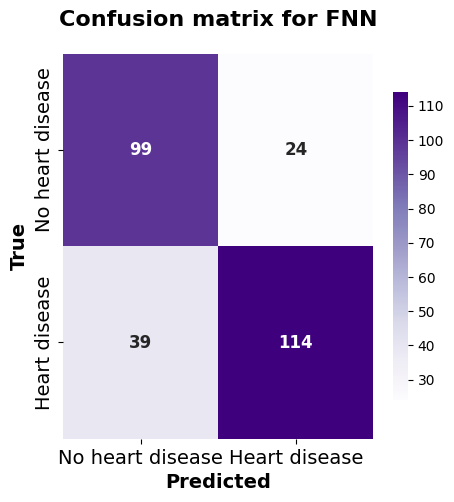

Most confusing classes: True label 1 --> predicted as 0


In [149]:
# Evaluate the model
fnn_evaluator = ModelEvaluator(fnn_model,"FNN",color_theme="Purples")
fnn_evaluator.summarize(X_test,y_test)

In [150]:
# Make predictions on the test set
predictions = fnn_model.predict(X_test)

results = pd.DataFrame({
    'Actual':y_test,
    'Predicted':predictions.flatten(),
    'Probability':predictions.flatten()
})

# Printing the results of predictions
print("Predictions vs Actual Labels:")
print("-" * 30)
print(results.head(10))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Predictions vs Actual Labels:
------------------------------
     Actual  Predicted  Probability
351       1   0.962377     0.962377
596       1   0.655388     0.655388
491       1   0.672534     0.672534
794       0   0.140669     0.140669
544       0   0.469182     0.469182
651       1   0.431151     0.431151
132       1   0.731031     0.731031
117       1   0.755911     0.755911
751       0   0.296271     0.296271
627       0   0.171068     0.171068
